## Notebook 3.

This notebook aims to incorporate weather station info as covariates to further enrich our models.

The preparation of the weather station info was done in a separate notebook. Daily weather variables including min/max/mean temperature, rainfall, wind speed, wind direction, gust speed, humidity, sunlight intensity are captured. We had three weather stations: Bana, Pala, Souroukoudingan. Bana market and Bana village shares the same weather info.

Weather station info did not cover the entire duration of the experiment, hence only count data between year 2017 and 2019 are included. Besides, as in notebook 2, we only look at wet season counts (May to October). As a result, the size of this subset is about 1/4 of the entire dataset.

In [1]:
# LOAD PACKAGES
require(compiler)
enableJIT(3)
require(doParallel)
require(lme4)
require(lmerTest)
require(MASS)
setMKLthreads(22)
# LOAD DATASET AND WEATHER INFO
load('Per house data PSC 2012 to 2019 polish2.RData')
load('BF_weather.RData')
ls()

Loading required package: compiler


[1] 3

Loading required package: doParallel
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: lme4
Loading required package: Matrix
Loading required package: lmerTest

Attaching package: 'lmerTest'

The following object is masked from 'package:lme4':

    lmer

The following object is masked from 'package:stats':

    step

Loading required package: MASS


[1] "BV_weather" "dat1"       "PL_weather" "SK_weather"

In [2]:
# SEE THE VARIABLE NAMES IN TO WEATHER INFO
names(SK_weather)

[1] "date"             "meantemp.c"       "maxtemp.c"        "mintemp.c"       
 [5] "humidity.percent" "winddir.deg"      "windspeed.kmhr"   "gustspeed.kmhr"  
 [9] "rain.mm"          "sun.wma2"

In [3]:
# TAKE SUBSET, YEAR 2017-2019 WHEN WEATHER INFO IS AVAILABLE
dat2<-dat1[dat1$date.collection>=min(PL_weather$date),]
# TAKE SUBSET, WET SEASON COUNTS ONLY (MAY TO OCTOBER ONLY)
dat2<-dat2[dat2$month.assigned %in% 5:10,]
# DIMENSION OF THE NEW DATASET?
dim(dat2)
names(dat2)
rm(dat1)
# TRANSFORM num.persons
persons.status<-dat2$num.persons
persons.status[dat2$num.persons>3]<-'Hi'
persons.status[dat2$num.persons<=3]<-'Low'
persons.status[dat2$num.persons==0]<-'None'

[1] 876  26

[1] "village"            "month.assigned"     "year.assigned"     
 [4] "monthyear.assigned" "day"                "month"             
 [7] "year"               "date.collection"    "site.id"           
[10] "longitude"          "latitude"           "room.id"           
[13] "num.persons"        "num.persons.remark" "mosquito.net"      
[16] "permanence"         "count.m"            "genotyped.m"       
[19] "col.m"              "gam.m"              "arab.m"            
[22] "count.f"            "genotyped.f"        "col.f"             
[25] "gam.f"              "arab.f"

Now the dataset has 876 rows, which is about 1/4 of the original size. It is slightly unfortunate but we have to make the most of it. 

Now I want to fit some "null" models without weather info with this new subset. We can then compare how much explanatory power is added when we include weather info in the subsequent models. 

In [4]:
# NULL MODEL WITHOUT WEATHER INFO
# THE INTERACTION IS HERE TO STAY (CHECKED)
overdispersion<-1:nrow(dat2)
m_0A<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned*village+mosquito.net+persons.status, 
             family='poisson', data=dat2, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_0A, correlation=FALSE)

fixed-effect model matrix is rank deficient so dropping 6 columns / coefficients

Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned * village + mosquito.net + persons.status
   Data: dat2
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  5641.8   5755.5  -2796.9   5593.8      818 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.29902 -0.36065 -0.01151  0.14073  0.61803 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.195722 1.09349 
 site.id        (Intercept) 0.632651 0.79539 
 year.assigned  (Intercept) 0.004086 0.06392 
Number of obs: 842, groups:  
overdispersion, 842; site.id, 174; year.assigned, 3

Fixed effects:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                             2.334353   0.372946   6.2

There is a warning saying some coefficients have been dropped, and that the summary table is missing several coefficient estimates. It is because some month.assigned x village combinations did not exist in our dataset. Let us have a quick look: 

In [5]:
by(dat2$count.f, interaction(dat2$month.assigned, dat2$village), mean, na.rm=T)

interaction(dat2$month.assigned, dat2$village): 1.Bana market
[1] NA
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 2.Bana market
[1] NA
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 3.Bana market
[1] NA
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 4.Bana market
[1] NA
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 5.Bana market
[1] 18.05128
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 6.Bana market
[1] 16.10345
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 7.Bana market
[1] 9.6
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 8.Bana market
[1] 12.5

We can see that in Pala and Souroukoudingan there were no data in months 05, 07, 09. This means we are unable to estimate some interaction terms, as the warning suggested earlier. 


One main challenge is to append weather into to the count dataset. The idea is to use date.collection (from the count dataset) and date (from the weather info dataset) as the key to merge the two datasets. Furthermore, I want to append weather info about several days before the sampling took place. This can be done easily when the dates are coded properly in R's date format, where arithmetic operations are allowed. Below is the script to do that. 

In [6]:
# A FUNCTION TO APPEND WEATHER INFO USING DATE. WITH LAGS
# ALWAYS GET FROM dat2
# YOU CAN IGNORE IT
f<-function(lag=0, lag_length=10)
{
    temp_date<-dat2$date.collection
    temp_village<-dat2$village
    # ONE PER VILLAGE
    temp<-data.frame(matrix(nc=lag_length, nr=length(temp_date)))
    temp_rain_SK<-temp; temp_rain_PL<-temp; temp_rain_BV<-temp;
    temp_temp_SK<-temp; temp_temp_PL<-temp; temp_temp_BV<-temp;
    temp_humid_SK<-temp; temp_humid_PL<-temp; temp_humid_BV<-temp;
    temp_wind_SK<-temp; temp_wind_PL<-temp; temp_wind_BV<-temp;
    temp_sun_SK<-temp; temp_sun_PL<-temp; temp_sun_BV<-temp;
    # THE COMBINED
    temp_rain<-temp; temp_temp<-temp; 
    temp_humid<-temp; temp_wind<-temp;
    temp_sun<-temp;
    for (i in 1:lag_length)
        {
        temp<-merge(temp_date-lag-i+1, SK_weather, by=1, all.x=T)
        temp_temp_SK[,i]<-temp[,2]
        temp_rain_SK[,i]<-temp[,9]
        temp_humid_SK[,i]<-temp[,5]
        temp_wind_SK[,i]<-temp[,7]
        temp_sun_SK[,i]<-temp[,10]
        temp<-merge(temp_date-lag-i+1, PL_weather, by=1, all.x=T)
        temp_temp_PL[,i]<-temp[,2]
        temp_rain_PL[,i]<-temp[,9]
        temp_humid_PL[,i]<-temp[,5]
        temp_wind_PL[,i]<-temp[,7]
        temp_sun_PL[,i]<-temp[,10]
        temp<-merge(temp_date-lag-i+1, BV_weather, by=1, all.x=T)
        temp_temp_BV[,i]<-temp[,2]
        temp_rain_BV[,i]<-temp[,9]
        temp_humid_BV[,i]<-temp[,5]
        temp_wind_BV[,i]<-temp[,7]
        temp_sun_BV[,i]<-temp[,10]
        }
    # NOW APPEND 
    SK<-temp_village=='Souroukoudingan'
    PL<-temp_village=='Pala'
    BV<-temp_village %in% c('Bana village', 'Bana market')
    temp_rain[SK,]<-temp_rain_SK[SK,]; temp_rain[PL,]<-temp_rain_PL[PL,]; temp_rain[BV,]<-temp_rain_BV[BV,]; 
    temp_temp[SK,]<-temp_temp_SK[SK,]; temp_temp[PL,]<-temp_temp_PL[PL,]; temp_temp[BV,]<-temp_temp_BV[BV,]; 
    temp_humid[SK,]<-temp_humid_SK[SK,]; temp_humid[PL,]<-temp_humid_PL[PL,]; temp_humid[BV,]<-temp_humid_BV[BV,]; 
    temp_wind[SK,]<-temp_wind_SK[SK,]; temp_wind[PL,]<-temp_wind_PL[PL,]; temp_wind[BV,]<-temp_wind_BV[BV,]; 
    temp_sun[SK,]<-temp_sun_SK[SK,]; temp_sun[PL,]<-temp_sun_PL[PL,]; temp_sun[BV,]<-temp_sun_BV[BV,]; 
    
    # GIVE COLUMN NAMES
    for (i in 1:lag_length)
        {
        names(temp_rain)[i]<-paste(c('rain.minus.', abs(-lag-i+1)), collapse='')
        names(temp_temp)[i]<-paste(c('temp.minus.', abs(-lag-i+1)), collapse='')
        names(temp_humid)[i]<-paste(c('humid.minus.', abs(-lag-i+1)), collapse='')
        names(temp_wind)[i]<-paste(c('wind.minus.', abs(-lag-i+1)), collapse='')
        names(temp_sun)[i]<-paste(c('sun.minus', abs(-lag-i+1)), collapse='')
        }
    return(cbind(dat2, temp_rain, temp_temp, temp_humid, temp_wind, temp_sun))
}
f<-cmpfun(f)

In [7]:
# LET'S TRY IT
dat3<-f(lag=0, lag_length=1)
dim(dat3)
names(dat3)

[1] 876  31

[1] "village"            "month.assigned"     "year.assigned"     
 [4] "monthyear.assigned" "day"                "month"             
 [7] "year"               "date.collection"    "site.id"           
[10] "longitude"          "latitude"           "room.id"           
[13] "num.persons"        "num.persons.remark" "mosquito.net"      
[16] "permanence"         "count.m"            "genotyped.m"       
[19] "col.m"              "gam.m"              "arab.m"            
[22] "count.f"            "genotyped.f"        "col.f"             
[25] "gam.f"              "arab.f"             "rain.minus.0"      
[28] "temp.minus.0"       "humid.minus.0"      "wind.minus.0"      
[31] "sun.minus0"

Now you can see that the count data matrix has more columns (there were 26 columns before). Those additional columns are the weather info. For example, rain.minus.0 is the rainfall on the day of sampling (hence minus.0 day). 

### With day 0 weather info

Let us focus on day 0's weather info. Running some plots may help feel the relationship between the counts and the two weather variables of interest: 

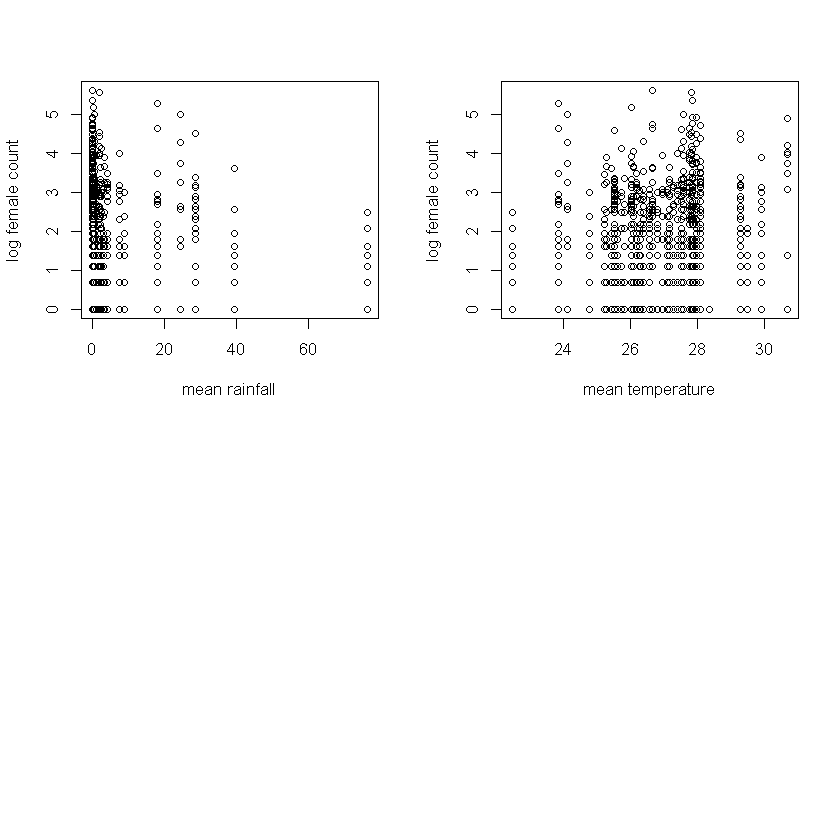

In [8]:
par(mfrow=c(2,2))
plot(dat3$rain.minus.0, log(dat3$count.f+1), xlab='mean rainfall', ylab='log female count')
plot(dat3$temp.minus.0, log(dat3$count.f+1), xlab='mean temperature', ylab='log female count')

I do not see any obvious trends, but let us build some models with these two weather variables. We build two models here: 1A with linear rainfall and temperature from day 0, 1B with quadratic terms. 

In [11]:
# MODEL 1A. DAY 0 TEMPERATURE AND RAINFALL, LINEAR
dat3<-f(lag=0, lag_length=1)
overdispersion<-1:nrow(dat3)
dat3$rain.minus.0<-scale(dat3$rain.minus.0) # SCALING
dat3$temp.minus.0<-scale(dat3$temp.minus.0)
m_1A<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned*village+mosquito.net+persons.status
            +rain.minus.0+temp.minus.0, 
             family='poisson', data=dat3, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_1A, correlation=FALSE)

fixed-effect model matrix is rank deficient so dropping 6 columns / coefficients
boundary (singular) fit: see ?isSingular

Correlation matrix not shown by default, as p = 23 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned * village + mosquito.net + persons.status +  
    rain.minus.0 + temp.minus.0
   Data: dat3
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  5619.6   5742.7  -2783.8   5567.6      816 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.32735 -0.38645 -0.00894  0.14145  0.78250 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.1362   1.0659  
 site.id        (Intercept) 0.6159   0.7848  
 year.assigned  (Intercept) 0.0000   0.0000  
Number of obs: 842, groups:  
overdispersion, 842; site.id, 174; year.assigned, 3

Fixed effects:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)               

In [12]:
# MODEL 1B. DAY 0 TEMPERATURE AND RAINFALL, ADD QUADRATIC VIA I(rain.minus.0^2)
dat3<-f(lag=0, lag_length=1)
overdispersion<-1:nrow(dat3)
dat3$rain.minus.0<-scale(dat3$rain.minus.0) # SCALING
dat3$temp.minus.0<-scale(dat3$temp.minus.0)
m_1B<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned*village+mosquito.net+persons.status
            +rain.minus.0+I(rain.minus.0^2)+temp.minus.0+I(temp.minus.0^2), 
             family='poisson', data=dat3, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_1B, correlation=FALSE)

fixed-effect model matrix is rank deficient so dropping 6 columns / coefficients
boundary (singular) fit: see ?isSingular

Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned * village + mosquito.net + persons.status +  
    rain.minus.0 + I(rain.minus.0^2) + temp.minus.0 + I(temp.minus.0^2)
   Data: dat3
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  5623.2   5755.8  -2783.6   5567.2      814 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.32114 -0.38260 -0.00605  0.14157  0.77649 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.1346   1.0652  
 site.id        (Intercept) 0.6175   0.7858  
 year.assigned  (Intercept) 0.0000   0.0000  
Number of obs: 842, groups:  
overdispersion, 842; site.id, 174; year.assigned, 3

Fixed effects:
                                       Estimate Std. Error z value

We have three observations here: First, after including day 0's rainfall and temperature we can get rid of the year effect, as its variance is estimated to be 0. Second, day o's temperature seems to a significant covariate. Third, we do not need the quadratic terms. 

The scaling of variables (scale them to have mean zero and unit variance) is only a mathematical trick to help convergence. 

### Include lagged rainfall as covariate

We now try to build more complex models which use the sum of rainfall in the previous days as a covariate. To be exact, we want to use the sum of rainfall between i and (i+j-1) days ago as the covariate. To find the best values for i and j, we run many glms with different combinations, and choose the one with the highest log-likelihood. 

In [18]:
dat3<-f(lag=0, lag_length=75)
#dim(dat3)
cat(paste('The 27-th column is', names(dat3)[27])) # MAKE SURE THE 27-TH COLUMN IS rain.minus.0
cl<-makeCluster(46, outfile='log.txt') # MULTIPLE CPU
registerDoParallel(cl)
result_rain<-foreach (i=1:30, .combine=rbind, .packages='lme4') %dopar%
    {
    setMKLthreads(1)
    temp_result<-rep(NA, 21)
    for (j in 1:length(temp_result))
        {
        total.rain<-apply(as.matrix(dat3[,(i+27):(i+27+j-1)]), 1, sum, na.rm=T)
        total.rain<-scale(total.rain) # SCALE TO CENTRE
        dat3$rain.minus.0<-scale(dat3$rain.minus.0)
        dat3$temp.minus.0<-scale(dat3$temp.minus.0)
        overdispersion<-1:nrow(dat3)
        m<-NA #RESET m
        m<-glmer(count.f~(1|site.id)+(1|overdispersion)+village*month.assigned+mosquito.net+persons.status
             +rain.minus.0+temp.minus.0+total.rain, 
            data=dat3, family='poisson', 
            control=glmerControl(optimizer="bobyqa"))
        temp_result[j]<-summary(m)$logLik
        cat(sprintf("%i, %i\n", i, j))
        }
    return(temp_result)
    }
stopCluster(cl)
dim(result_rain)
invisible(gc())

The 27-th column is rain.minus.0

[1] 30 21

It takes a while to run hundreds of glms. Now we plot the maximised log-likelihood against i and j in a 3D plot. We also would like to know which combination of i and j gives the highest log-likelihood. 

[1] -2776.847

,row,col
result.3,3,1


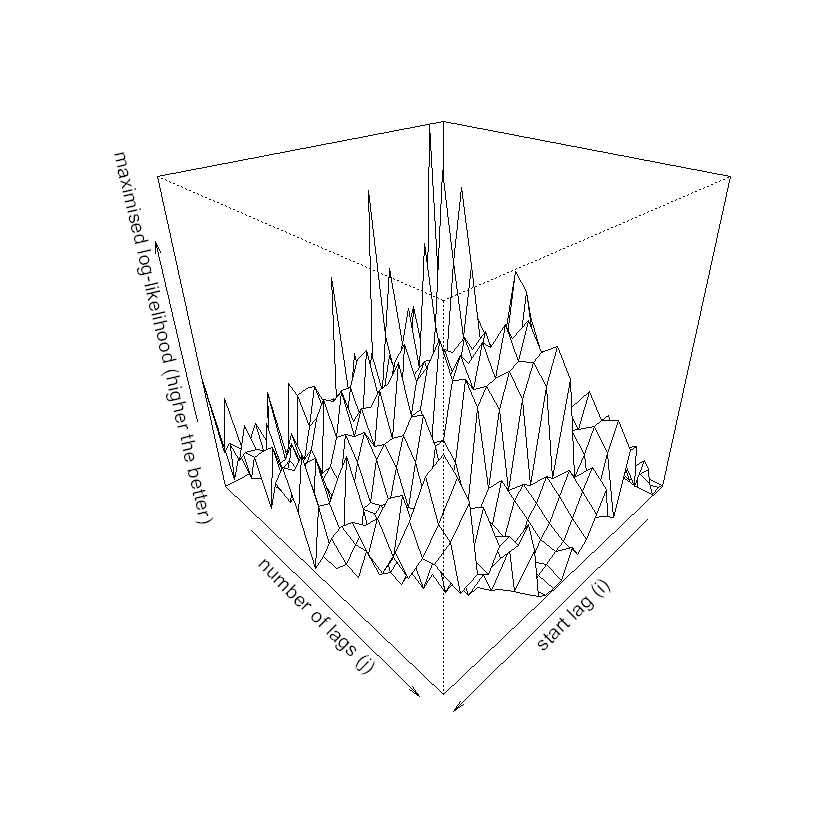

In [23]:
persp(1:nrow(result_rain), 1:ncol(result_rain), result_rain, theta=135, phi=30, 
        xlab='start lag (i)', ylab='number of lags (j)', zlab='maximised log-likelihood (higher the better)')
# HIGHEST LOG-LIKE
max(result_rain, na.rm=T)
# THE VALUE OF i AND j GIVES THE HIGHEST LOG-LIKE
which(result_rain==max(result_rain, na.rm=T), arr.ind=TRUE)

The highest log-likelihood is attained when i=3 and j=1 (i.e. the rainfall 3 days ago). 

Ace suggested to use a Gaussian-like weighted sum for rainfall. 

In [20]:
dat3<-f(lag=0, lag_length=75)
cat(paste('The 27-th column is', names(dat3)[27])) # MAKE SURE THE 27-TH COLUMN IS rain.minus.0
cl<-makeCluster(46, outfile='log.txt') # MULTIPLE CPU
registerDoParallel(cl)
result_rain_gaussian<-foreach (i=1:30, .combine=rbind, .packages='lme4') %dopar%
    {
    setMKLthreads(1)
    sd<-seq(0.4, 4, 0.4) # MAX SD CONSIDERED IS 4
    temp_result<-rep(NA, length(sd))
    for (j in 1:length(temp_result))
        {
        # FIGURE OUT THE GAUSSIAN MAX AND MIN, CUT-OFF IS 3*SD
        lower<-floor(i-3*sd[j])
        if (lower<1) {lower<-1} # CAN'T HAVE NEGATIVE LAGS
        upper<-ceiling(i+3*sd[j])
        temp<-dnorm(lower:upper, mean=i, sd=sd[j])
        weight<-temp/sum(temp) # NORMALISE WEIGHTS, SUM TO ONE
        temp.total.rain<-as.matrix(dat3[,(lower+27):(upper+27)])
        total.rain<-as.vector(temp.total.rain%*%weight)
        total.rain<-scale(total.rain) # SCALE TO CENTRE
        dat3$rain.minus.0<-scale(dat3$rain.minus.0)
        dat3$temp.minus.0<-scale(dat3$temp.minus.0)
        overdispersion<-1:nrow(dat3)
        m<-NA
        # FAIL CASES OCCUR SO USE TRY
        m<-glmer(count.f~(1|site.id)+(1|overdispersion)+village+month.assigned+mosquito.net+persons.status
             +rain.minus.0+temp.minus.0+total.rain, 
            data=dat3, family='poisson', 
            control=glmerControl(optimizer="bobyqa"))
        temp_result[j]<-summary(m)$logLik
        cat(sprintf("%i, %i\n", i, j))
        }
    return(temp_result)
    }
stopCluster(cl)
dim(result_rain_gaussian)
invisible(gc())

The 27-th column is rain.minus.0

[1] 30 10

[1] -2789.546

,row,col
result.16,16,1


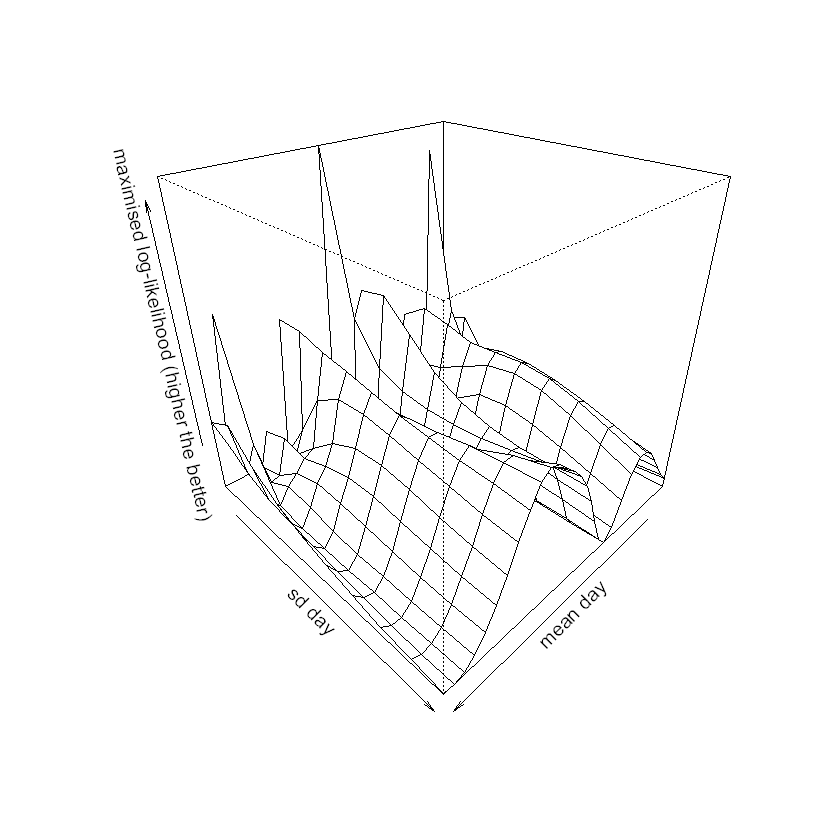

In [24]:
persp(1:nrow(result_rain_gaussian), 1:ncol(result_rain_gaussian), result_rain_gaussian, theta=135, phi=30, 
        xlab='mean day', ylab='sd day', zlab='maximised log-likelihood (higher the better)')
max(result_rain_gaussian, na.rm=T)
which(result_rain_gaussian==max(result_rain_gaussian, na.rm=T), arr.ind=TRUE)

Including past rainfall as a covariate increases explanatory power. Although it is a signficant term I would not say there is a drastic improvement. The results above differ from what I reported before because different subsets of data were used. 

### Lagged rainfall + log male count

In [25]:
dat3<-f(lag=0, lag_length=75)
#dim(dat3)
cat(paste('The 27-th column is', names(dat3)[27])) # MAKE SURE THE 27-TH COLUMN IS rain.minus.0
cl<-makeCluster(46, outfile='log.txt') # MULTIPLE CPU
registerDoParallel(cl)
result_rain2<-foreach (i=1:30, .combine=rbind, .packages='lme4') %dopar%
    {
    setMKLthreads(1)
    temp_result<-rep(NA, 21)
    for (j in 1:length(temp_result))
        {
        total.rain<-apply(as.matrix(dat3[,(i+27):(i+27+j-1)]), 1, sum, na.rm=T)
        total.rain<-scale(total.rain) # SCALE TO CENTRE
        dat3$rain.minus.0<-scale(dat3$rain.minus.0)
        dat3$temp.minus.0<-scale(dat3$temp.minus.0)
        log.count.m<-log(dat3$count.m+1)
        overdispersion<-1:nrow(dat3)
        m<-NA #RESET m
        m<-glmer(count.f~(1|site.id)+(1|overdispersion)+village*month.assigned+mosquito.net+persons.status
             +rain.minus.0+temp.minus.0+total.rain+log.count.m, 
            data=dat3, family='poisson', 
            control=glmerControl(optimizer="bobyqa"))
        temp_result[j]<-summary(m)$logLik
        cat(sprintf("%i, %i\n", i, j))
        }
    return(temp_result)
    }
stopCluster(cl)
dim(result_rain2)
invisible(gc())

The 27-th column is rain.minus.0

[1] 30 21

[1] -2643.981

,row,col
result.11,11,1


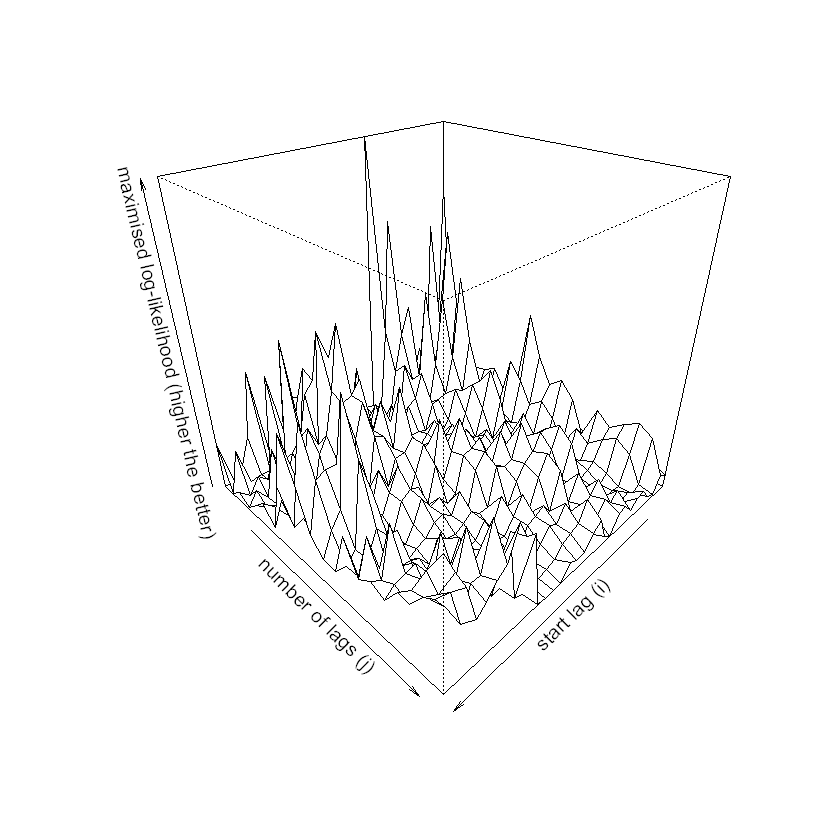

In [26]:
persp(1:nrow(result_rain2), 1:ncol(result_rain2), result_rain2, theta=135, phi=30, 
        xlab='start lag (i)', ylab='number of lags (j)', zlab='maximised log-likelihood (higher the better)')
# HIGHEST LOG-LIKE
max(result_rain2, na.rm=T)
# THE VALUE OF i AND j GIVES THE HIGHEST LOG-LIKE
which(result_rain2==max(result_rain2, na.rm=T), arr.ind=TRUE)

A different result is obtained when log male count is also included. It is safe to say that log male count is a more useful covariate as it increases the log-likelihood by 150. 